In [1]:
!pip install kaggle

In [0]:
!mkdir ~/.kaggle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/gdrive/My\ Drive/kaggle.json ~/.kaggle/kaggle.json

In [10]:
!kaggle competitions download -c quora-insincere-questions-classification -p /content

 95% 15.0M/15.8M [00:00<00:00, 27.1MB/s]
100% 15.8M/15.8M [00:00<00:00, 44.5MB/s]
 75% 41.0M/54.9M [00:00<00:00, 32.9MB/s]
100% 54.9M/54.9M [00:00<00:00, 66.5MB/s]
100% 4.09M/4.09M [00:00<00:00, 18.1MB/s]

100% 5.96G/5.96G [02:11<00:00, 23.4MB/s]
100% 5.96G/5.96G [02:11<00:00, 48.6MB/s]


In [11]:
!unzip \*.zip

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  

4 archives were successfully processed.


In [0]:
import pandas as pd
df_train=pd.read_csv('/content/train.csv')
df_test=pd.read_csv('/content/test.csv')

In [13]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [14]:
df_test.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [15]:
df_train['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [16]:
#preprocessing the dataset
import nltk
import re
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')

s_w = set(stopwords.words('english'))

def stop_words(string):
    return ' '.join([x for x in word_tokenize(string) if not x in s_w])

def clean_strings(string1):
  new_string=re.sub('[\n]',' ',string1) #removing newline character
  new_string=re.sub('[^a-zA-Z]',' ',new_string) #removing non alpha characters
  new_string=stop_words(new_string) #removing stopwords
  return new_string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
questions=[]
targets=[]
for i in range(len(df_train)):
  targets.append(df_train['target'][i])
  questions.append(clean_strings(df_train['question_text'][i]))

In [0]:
test_question=[]
for i in range(len(df_test)):
  test_question.append(clean_strings(df_train['question_text'][i]))

In [0]:
#splitting the data into train and test sets 
from sklearn.model_selection import train_test_split
train_questions, test_questions, train_targets, test_targets= train_test_split(questions, targets, test_size=0.2, shuffle= True)

In [20]:
print('Data: ',len(df_train))
print('Training examples: ',len(train_questions))
print('Test examples: ',len(test_questions))

Data:  1306122
Training examples:  1044897
Test examples:  261225


In [21]:
#data tokenizing and padding
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


embed_dim = 300
max_len = 100
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"
voc_len=49999


tokenizer = Tokenizer(num_words=voc_len+1,oov_token=oov_tok)
tokenizer.fit_on_texts(questions)

word_index = tokenizer.word_index
voc_size=len(word_index)
print('Original Size of Vocabulary: ',voc_size)

word_index = {e:i for e,i in word_index.items() if i <= voc_len+1} #Reducing the Size of Vocabulary
print('New Size of Vocabulary: ',len(word_index))

seq = tokenizer.texts_to_sequences(questions)
pad = pad_sequences(seq, maxlen=max_len, padding=pad_type, truncating=trunc_type)

train_seq = tokenizer.texts_to_sequences(train_questions)
train_pad = pad_sequences(train_seq, maxlen=max_len, padding=pad_type, truncating=trunc_type)

test_seq = tokenizer.texts_to_sequences(test_questions)
test_pad = pad_sequences(test_seq, maxlen=max_len, padding=pad_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_question)
test_padd = pad_sequences(test_sequences, maxlen=max_len, padding=pad_type, truncating=trunc_type)

train_targets=np.expand_dims(train_targets, axis=1)
test_targets=np.expand_dims(test_targets, axis=1)

Original Size of Vocabulary:  178863
New Size of Vocabulary:  50000


**BIDIRECTIONAL LSTM**

In [22]:
#Bidirectional LSTM model building
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(voc_len+1, embed_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(64,return_sequences=True)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [23]:
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='auto')
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
num_epoch = 5
his=model.fit(train_pad, train_targets, epochs=num_epoch, batch_size=512, validation_data=(test_pad,test_targets),callbacks=[reduce],verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1044897 samples, validate on 261225 samples
Epoch 1/5
1044897/1044897 [==============================] - 89s 85us/sample - loss: 0.1290 - acc: 0.9504 - val_loss: 0.1200 - val_acc: 0.9536
Epoch 2/5
1044897/1044897 [==============================] - 76s 73us/sample - loss: 0.1162 - acc: 0.9555 - val_loss: 0.1175 - val_acc: 0.9542
Epoch 3/5
1044897/1044897 [==============================] - 76s 73us/sample - loss: 0.1106 - acc: 0.9579 - val_loss: 0.1160 - val_acc: 0.9553
Epoch 4/5
1044897/1044897 [==============================] - 76s 73us/sample - loss: 0.1060 - acc: 0.9599 - val_loss: 0.1159 - val_acc: 0.9552
Epoch 5/5
1044897/1044897 [==============================] - 76s 73us/sample - loss: 0.1016 - acc: 0.9619 - val_loss: 0.1194 - val_acc: 0.9554


In [24]:
#Determining the optimal threshold value
pred = model.predict(test_pad, batch_size=512,verbose=1)
from sklearn import metrics
for th in np.arange(0.1, 0.501, 0.05):
    th = np.round(th, 2)
    print("F1 score at threshold {0} is {1}".format(th, metrics.f1_score(test_targets, (pred>th).astype(int))))

261225/261225 [==============================] - 6s 22us/sample
F1 score at threshold 0.1 is 0.5927251864601262
F1 score at threshold 0.15 is 0.6182499114327649
F1 score at threshold 0.2 is 0.6268835012081557
F1 score at threshold 0.25 is 0.6303023336015634
F1 score at threshold 0.3 is 0.6275267000543052
F1 score at threshold 0.35 is 0.6218274913872118
F1 score at threshold 0.4 is 0.6110982429436483
F1 score at threshold 0.45 is 0.5968705744188457
F1 score at threshold 0.5 is 0.5790595973833531


              precision    recall  f1-score   support

           0       0.97      0.98      0.98    244918
           1       0.66      0.57      0.61     16307

    accuracy                           0.96    261225
   macro avg       0.82      0.77      0.79    261225
weighted avg       0.95      0.96      0.95    261225

[[240238   4680]
 [  7073   9234]]


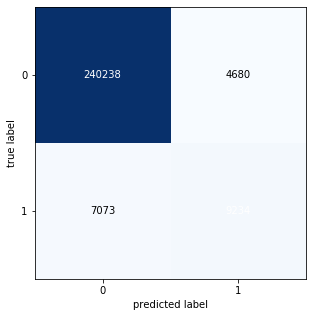

In [26]:
# From above, F1 score is highest at a threshold of 0.25
pred_test_targets=(pred>0.25).astype(int)

from sklearn.metrics import classification_report
print(classification_report(test_targets,pred_test_targets))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_targets, pred_test_targets))
cm = confusion_matrix(test_targets, pred_test_targets)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))

import matplotlib.pyplot as plt
plt.show()

In [29]:
#predicting the labels of test data by passing the test data through the model
pred = model.predict(test_padd, batch_size=512,verbose=1)
pred_test_targets = (pred>0.25).astype(int)

375806/375806 [==============================] - 8s 22us/sample


In [0]:
df_output = pd.DataFrame({'qid':df_test['qid'].values})
df_output['prediction'] = pred_test_targets
df_output.to_csv('submission.csv', index=False)

In [31]:
out_df=pd.read_csv('submission.csv')
out_df['prediction'].value_counts()

0    355659
1     20147
Name: prediction, dtype: int64